In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as io
import scipy.signal as signal
from scipy.optimize import curve_fit
import logging
import importlib
import os


import ephys_extractor as efex
import ephys_features as ft
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [112]:
# Normally you don't change modules though
importlib.reload(efex)
importlib.reload(ft)

<module 'ephys_features' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py'>

# Load and process data

In [207]:
# M1 data .mat files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
M1 = []
M1_names = []
for root, dirs, files in os.walk('../M1/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                M1.append(io.loadmat(root + '/' + file))
                M1_names.append(root + '/' + file)

In [208]:
list(M1_names)

['../M1/2018/sept/09 18 2018/09 18 2018 sample 1.mat',
 '../M1/2018/sept/09 18 2018/09 18 2018 sample 2.mat',
 '../M1/2018/sept/09 18 2018/09 18 2018 sample 3.mat',
 '../M1/2018/sept/09 17 2018/09 17 2018 sample 4.mat',
 '../M1/2018/sept/09 17 2018/09 17 2018 sample 1.mat',
 '../M1/2018/sept/09 17 2018/09 17 2018 sample 2.mat',
 '../M1/2018/sept/09 17 2018/09 17 2018 sample 5.mat',
 '../M1/2018/sept/09 17 2018/09 17 2018 sample 3.mat',
 '../M1/2018/sept/09 11 2018/09 11 2018 sample 1.mat',
 '../M1/2018/sept/09 11 2018/09 11 2018 sample 6.mat',
 '../M1/2018/sept/09 11 2018/09 11 2018 sample 2.mat',
 '../M1/2018/sept/09 11 2018/09 11 2018 sample 3.mat',
 '../M1/2018/sept/09 11 2018/09 11 2018 sample 5.mat',
 '../M1/2018/sept/09 05 2018/09 05 2018 sample 2.mat',
 '../M1/2018/sept/09 05 2018/09 05 2018 sample 1.mat',
 '../M1/2018/sept/09 10 2018/09 10 2018 sample 2.mat',
 '../M1/2018/sept/09 10 2018/09 10 2018 sample 3.mat',
 '../M1/2018/sept/09 13 2018/09 13 2018 sample 2.mat',
 '../M1/20

In [ ]:
# Microcolumn data
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
MicroColumn = []
MicroColumn_names = []
for root, dirs, files in os.walk('../Microcolumn/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                MicroColumn.append(io.loadmat(root + '/' + file))
                MicroColumn_names.append(root + '/' + file)

In [ ]:
# First data that was available
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
Prel = []
Prel_names = []
for root, dirs, files in os.walk('../data/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                Prel.append(io.loadmat(root + '/' + file))
                Prel_names.append(root + '/' + file)

In [ ]:
# M1 data asc files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root)
M1_asc = []
for root, dirs, files in os.walk('../M1/'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                M1_asc.append(io.loadmat(root + '/' + file))
destinations = ['../M1/L5/01 02 2018/sample1splitfiles/', '../M1/L5/01 02 2018/sample4splitfiles/', \
                '../M1/L5/01 03 2018/sample2splitfiles/', '../M1/L5/01 03 2018/sample7splitfiles/', \
                '../M1/L5/01 04 2018/sample3splitfiles/']
dictionary = dict([('files', M1_asc), ('destinations', destinations)])


In [ ]:
# M1 L5 .asc data
# '../M1/L5/01 02 2018/01 02 2018 sample 1.asc' apparantly is redundant, a .mat file exists already for that sample
files = ['../M1/L5/01 02 2018/01 02 2018 sample 4.asc', \
         '../M1/L5/01 03 2018/01 03 2018 sample 2.asc', '../M1/L5/01 03 2018/01 03 2018 sample 7.asc', \
         '../M1/L5/01 04 2018/01 04 2018 sample 3.asc']

# '../M1/L5/01 02 2018/sample1splitfiles/' is the redundant subdirectory that would have to be made
destinations = ['../M1/L5/01 02 2018/sample4splitfiles/', \
                '../M1/L5/01 03 2018/sample2splitfiles/', '../M1/L5/01 03 2018/sample7splitfiles/', \
                '../M1/L5/01 04 2018/sample3splitfiles/']
dictionary = dict([('files', files), ('destinations', destinations)])

In [209]:
def data_preparation(data, el_num = 2, current_step = 20):
    """Analyse the data in dictionary format (assumes a certain outlook of the data) and return the voltage traces, 
    stimulus current magnitudes for all traces, the time and the current index for which the current magnitude equals 0 pA.

    Parameters
    ----------
    data : dictionary full of voltage (V) and time (s) traces
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    voltage : numpy 2D array of voltage traces (mV)
    time : numpy 1D array of time points (s)
    current : numpy 1D array of current stimulus magnitudes
    curr_index_0 : integer of current index where the current = 0 pA
    """
    
    
    
    # All the keys in the dictionary should have the form "Trace_1_j_c_el" where j represents a certain number which could
    # be different between cells/samples, therefore we will store this number as num. c represents the current stimulus
    # magnitude index, el the electrode number. They usually always record from electrode number el = 2.
    num = list(data)[0].split('_')[2]
    n_samp = data[list(data.keys())[0]].shape[0] # Amount of timepoints
    dt = data[list(data.keys())[0]][1, 0] - data [list(data.keys())[0]][0, 0] # Time step
    time = np.arange(0,n_samp*dt,dt)
    
    # We pick random voltage traces to look for the resting membrane voltage
    Vm_tuple = []
    
    # Check whether we have hyperpolarisation in the beginning, otherwise the electrode where spikes have been recorded must have
    # been a different one
    object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                                   start = 0.1, end = 0.7, filter = 10)
    voltage_deflection_v, _ = object_ephys.voltage_deflection()
    Vm = object_ephys._get_baseline_voltage()
    V_defl = voltage_deflection_v
    if  np.abs(Vm - V_defl) < 2:
        el_num = 1
        while np.abs(Vm - V_defl) < 2:
            object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                                   start = 0.1, end = 0.7, filter = 10)
            Vm = object_ephys._get_baseline_voltage()
            V_defl, _ = object_ephys.voltage_deflection()
            if el_num == 1: # We already investigated el_num = 2
                el_num = 3
            else: el_num += 1
        el_num = el_num - 1
    #for i in np.arange(1, 12, 1):
    #    voltage_trace = data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1]
    #    object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*voltage_trace, start = 0.1, end = 0.7, filter = 10)
    #    Vm = object_ephys._get_baseline_voltage()
    #    Vm_tuple.append(Vm)
    #Vm = np.mean(np.array(Vm_tuple))
    
    Amount_Of_Electrodes = np.max([int(g.split('_')[-1]) if (g.split('_')[0] == 'Trace') else 0 for g in list(data.keys())])
    
    # stim_paradigm_num is the number of current stimulus magnitudes that were used
    stim_paradigm_num = (np.array(list(data)).size - 3)/Amount_Of_Electrodes
                                    # 3 keys should just be '__globals__', '__header__', and '__version__'
 
    curr_index_0 = 0 # Current stimulus magnitude index that corresponds to stimulating the cell with 0 pA
    
    # Trace with the least amount of variance in the trace is assumed to be the trace corresponding to stimulating the cell
    # with 0 pA stimulation current
    best = np.var(1000*data['Trace_1_{}_{}_{}'.format(num, 1, el_num)][:, 1])
    #best = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, 1, el_num)][:, 1]) - Vm)
    for i in np.arange(2, stim_paradigm_num + 1, 1, dtype = 'int'):
        best_temp = np.var(1000*data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1])
        #best_temp = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1]) - Vm)
        if  best_temp < best:
            best = best_temp
            curr_index_0 = i
    
    start_current_impulse = -(curr_index_0 - 1)*current_step # - 1 since in the dictionary we start at 1 (not at zero)    
    stop_current_impulse = start_current_impulse + (current_step*stim_paradigm_num)
    current = np.arange(start_current_impulse, stop_current_impulse, current_step)
    #current = current[current < 800] #After that the cell might die and it's probably innecessary for the analysis
    
    # voltage will give us the voltage response for all different current steps
    voltage = np.zeros((n_samp, len(current)))
    for c, C in enumerate(current):
        voltage[:,c] = 1000*data['Trace_1_{}_{}_{}'.format(num, c+1, el_num)][:,1] # c+1: goes from 1 to end of possible current
                                                                                   # stimulation magnitudes
    
    return time, current, voltage, (curr_index_0 - 1) # -1 since the current and voltage vector start at 0

In [ ]:
def data_preparation_asc(file, out_directory, splitLen = 22503, outputBase = 'sample_', el_num = 2, current_step = 20):
    '''Same as data_preparation but handles asc files
        
    Parameters
    ----------
    file : asc file of voltage (V) and time (s) traces
    out_directory : directory to output subfiles to
    splitLen : amount of lines every subfile should contain after splitting the file (optional, 22503 by default)
    outputBase : standard prefix for name of subfiles (optional, 'sample_' by default)
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    voltage : numpy 2D array of voltage traces (mV)
    time : numpy 1D array of time points (s)
    current : numpy 1D array of current stimulus magnitudes
    curr_index_0 : integer of current index where the current = 0 pA
    '''
    
    # Creating out_directory if it does not exist yet
    if not os.path.exists(out_directory):
        os.makedirs(out_directory)
    
    # Splitting the file
    input = open(file, 'r').read().split('\n') # Make a list of lines splitted by '\n'

    at = 1
    for lines in range(0, len(input), splitLen):
        # First, get the list slice
        outputData = input[lines:lines+splitLen]

        # Now open the output file, join the new slice with newlines
        # and write it out. Then close the file.
        output = open(out_directory + outputBase + str(at) + '.txt', 'w')
        output.write('\r\n'.join(outputData))
        output.close()

        # Increment the counter
        at += 1
    
    
    # Getting the voltage and time traces
    amount_of_subfiles = round(len(input)/splitLen)
    names = ['index', 'time_1', 'V_1', 'time_2', 'V_2', 'time_3', 'V_3', 'time_4', 'V_4', 'time_5', 'V_5', \
         'time_6', 'V_6', 'time_7', 'V_7', 'time_8', 'V_8']
    data = pd.read_csv(out_directory + outputBase + str(1) + '.txt', skiprows = 3, names = names)
    n_samp = data['time_2'].values.shape[0] # Amount of timepoints
    dt = data['time_2'].values[1] - data['time_2'].values[0] # Time step
    time = np.arange(0,n_samp*dt,dt)
    voltage =  np.zeros((n_samp, amount_of_subfiles))
    voltage[:, 0] = 1000*data['V_{}'.format(el_num)].values
    for i in np.arange(2, amount_of_subfiles + 1, 1):
        data = pd.read_csv(out_directory + outputBase + str(i) + '.txt', skiprows = 3, names = names)
        voltage[:, i-1] = 1000*data['V_{}'.format(el_num)].values
    
    # We pick random voltage traces to look for the resting membrane voltage
    Vm_tuple = []
    
    for i in np.arange(1, 12, 1):
        object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, i], start = 0.1, end = 0.7, filter = 10)
        Vm = object_ephys._get_baseline_voltage()
        Vm_tuple.append(Vm)
    Vm = np.mean(np.array(Vm_tuple))
    
    
    # The trace where the voltage does not differ much with the membrane voltage is the trace with stimulus current I = 0 pA.
    # We can use this information to determine at which negative current stimulus magnitude the experiment started.
    curr_index_0 = 0 # Current stimulus magnitude index that corresponds to stimulating the cell with 0 pA
    best = np.abs(np.mean(voltage[:, 0]) - Vm)
    for i in np.arange(1, amount_of_subfiles, 1, dtype = 'int'):
        best_temp = np.abs(np.mean(voltage[:, i]) - Vm)
        if  best_temp < best:
            best = best_temp
            curr_index_0 = i
    start_current_impulse = -curr_index_0*current_step  
    stop_current_impulse = start_current_impulse + (current_step*amount_of_subfiles)
    current = np.arange(start_current_impulse, stop_current_impulse, current_step)
    #current = current[current < 800]
    
    return time, current, voltage, curr_index_0

In [205]:
data = io.loadmat('../M1/2018/mar/03 29 2018/03 29 2018 sample 8.mat')

In [182]:
data1 = io.loadmat('../M1/2018/may/05 09 2018/05 09 2018 sample 4.mat')

In [193]:
data

{'Trace_1_6_100_1': array([[ 0.00000000e+00,  6.25093089e-05],
        [ 4.00000000e-05,  6.25093089e-05],
        [ 8.00000000e-05,  6.25093089e-05],
        ...,
        [ 9.99880000e-01,  0.00000000e+00],
        [ 9.99920000e-01, -3.12546545e-05],
        [ 9.99960000e-01,  3.12546545e-05]]),
 'Trace_1_6_100_2': array([[ 5.00000000e-06, -7.51538575e-02],
        [ 4.50000000e-05, -7.51491785e-02],
        [ 8.50000000e-05, -7.51435086e-02],
        ...,
        [ 9.99885000e-01, -7.49685690e-02],
        [ 9.99925000e-01, -7.49719217e-02],
        [ 9.99965000e-01, -7.49741197e-02]]),
 'Trace_1_6_100_3': array([[ 1.00000000e-05, -5.20493995e-05],
        [ 5.00000000e-05, -5.17910375e-05],
        [ 9.00000000e-05, -5.15320571e-05],
        ...,
        [ 9.99890000e-01, -7.93853469e-05],
        [ 9.99930000e-01, -8.04969459e-05],
        [ 9.99970000e-01, -8.16077518e-05]]),
 'Trace_1_6_100_4': array([[ 1.00000000e-05,  9.37583463e-05],
        [ 5.00000000e-05, -3.12527809e-05],

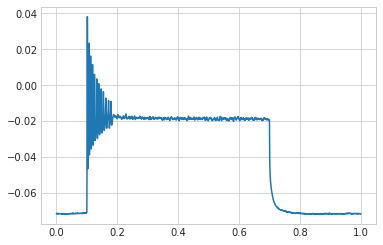

In [198]:
plt.plot(data['Trace_1_6_50_2'][:, 0], data['Trace_1_6_50_2'][:, 1] )

In [206]:
time, current, voltage, curr_index_0 = data_preparation(data, el_num = 2)
print('time: ', time)
print('\n\ncurrent: ', current)
print('\n\nvoltage: ', voltage)
print('\n\ncurr_index_0: ', curr_index_0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
time:  [0.0000e+00 4.0000e-05 8.0000e-05 ... 8.9988e-01 8.9992e-01 8.9996e-01]


current:  [-200. -180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.
   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.  260.
  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.  500.
  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.  740.
  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.  980.
 1000. 1020. 1040. 1060. 1080. 1100. 1120. 1140. 1160. 1180. 1200. 1220.
 1240. 1260. 1280. 1300. 1320. 1340. 1360. 1380.]


voltage:  [[-66.37541205 -65.78193605 -65.6548813  ... -68.09920818 -68.05337965
  -68.05130839]
 [-66.37629867 -65.76757878 -65.64570963 ... -68.09227914 -68.06439161
  -68.05910915]
 [-66

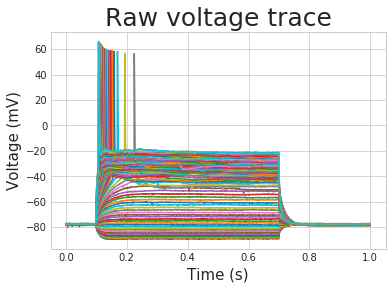

In [185]:
plt.plot(time, voltage)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)
plt.savefig('./RawVoltageTraceExample1.png')

In [95]:
dvdt = ft.calculate_dvdt(voltage[:, 19], time)

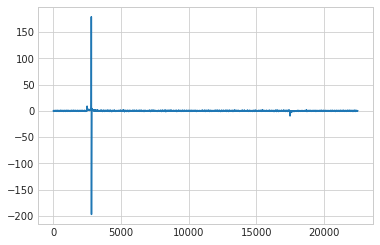

In [96]:
plt.plot(dvdt)

In [ ]:
time_asc, current_asc, voltage_asc, curr_index_0_asc = data_preparation_asc('../M1/L5/01 02 2018/01 02 2018 sample 1.asc', \
                                                            '../M1/L5/01 02 2018/sample1splitfiles/')
print('time: ', time_asc)
print('\n\ncurrent: ', current_asc)
print('\n\nvoltage: ', voltage_asc)
print('\n\ncurr_index_0 ', curr_index_0_asc)

# Analysing spikes

In [116]:
def extract_spike_features(time, current, voltage, start = 0.1, end = 0.7, fil = 10):
    """ Analyse the voltage traces and extract information for every spike (returned in df), and information for all the spikes
    per current stimulus magnitude.

    Parameters
    ----------
    time : numpy 1D array of the time (s)
    current : numpy 1D array of all possible current stimulation magnitudes (pA)
    voltage : numpy ND array of all voltage traces (mV) corresponding to current stimulation magnitudes
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    df : DataFrame with information for every detected spike (peak_v, peak_index, threshold_v, ...)
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    """
    
    df = pd.DataFrame()
    df_related_features = pd.DataFrame()
    for c, curr in enumerate(current):
        current_array = curr*np.ones_like(time)
        start_index = (np.abs(time - start)).argmin() # Find closest index where the injection current starts
        end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
        current_array[:start_index] = 0
        current_array[end_index:len(current_array)] = 0
        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = start, \
                                                      end = end, filter = fil)
        EphysObject.process_spikes()
        #if EphysObject._spikes_df.size:
        #    #Random threshold 15 for now but:
        #    if np.abs(EphysObject._get_baseline_voltage() - np.mean(EphysObject._spikes_df['threshold_v'].values)) < 15:
        #        print('Too steep depolarisation here.')
        #        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = 0.1005, \
        #                                                     end = end, filter = fil)
        
        # Adding peak_height (mV) + code for maximum frequency determination (see further)
        spike_count = 0
        if EphysObject._spikes_df.size:
            EphysObject._spikes_df['peak_height'] = EphysObject._spikes_df['peak_v'].values - \
                                                   EphysObject._spikes_df['threshold_v'].values
            spike_count = EphysObject._spikes_df['threshold_i'].values.size
        df = pd.concat([df, EphysObject._spikes_df])

        # Some easily found extra features
        df_features = EphysObject._sweep_features

        # Adding spike count
        df_features.update({'spike_count': spike_count})
        
        # Adding current (pA)
        df_features.update({'current': curr})

        # Adding membrane voltage (mV)
        df_features.update({'resting_membrane_potential': EphysObject._get_baseline_voltage()})

        # Adding voltage deflection (mV)
        voltage_deflection_v, voltage_deflection_i = EphysObject.voltage_deflection()
        df_features.update({'voltage_deflection': voltage_deflection_v})
        
        # Adding input resistance (MOhm)
        # How to calculate the input resistance is not clear yet but this could be an option (although in function
        # get_cell_features it is being calculated differently)
        input_resistance = np.nan
        if not ('peak_i' in EphysObject._spikes_df.keys()) and not curr==0: # We only calculate input resistances 
                                                                            # from traces without peaks
            input_resistance = (np.abs(voltage_deflection_v - EphysObject._get_baseline_voltage())*1000)/np.abs(curr)
            if input_resistance == np.inf:
                input_resistance = np.nan
        df_features.update({'input_resistance': input_resistance})

        # Adding membrane time constant (s) and voltage plateau level for hyperpolarisation paradigms after stimulus onset
        tau = np.nan
        E_plat = np.nan
        if curr < 0: # We use hyperpolarising steps as required in the object function to estimate the membrane time constant
                     # and E_plateau
            tau = EphysObject.estimate_time_constant()  # Result in seconds!
            E_plat = ft.average_voltage(voltage[:, c], time, start = end - 0.1, end = end)
        df_features.update({'tau': tau})
        df_features.update({'E_plat': E_plat})


        df_related_features = pd.concat([df_related_features, pd.DataFrame([df_features])])
    
    return df, df_related_features

In [109]:
df, df_related_features = extract_spike_features(time, current, voltage)

In [ ]:
plt.plot(time, voltage[:, 13])

In [ ]:
np.where(df.loc[0]['fast_trough_i'].values > 0)[0][0]

In [ ]:
df.loc[0]['threshold_v'].values[11]

In [110]:
df

,threshold_index,clipped,trough_index,trough_t,trough_v,trough_i,threshold_t,threshold_v,threshold_i,peak_index,...,fast_trough_t,fast_trough_v,fast_trough_i,slow_trough_index,slow_trough_t,slow_trough_v,slow_trough_i,width,upstroke_downstroke_ratio,peak_height
0,2864,False,2896.0,0.11584,-45.453154,180.0,0.11456,-26.263909,180.0,2872,...,0.11552,-44.795774,180.0,NaN,NaN,NaN,NaN,0.00032,1.676788,82.923835
0,2748,False,2775.0,0.11100,-45.390546,200.0,0.10992,-27.891709,200.0,2757,...,0.11096,-45.327939,200.0,NaN,NaN,NaN,NaN,0.00036,1.609272,86.774206
1,3512,False,6474.0,0.25896,-28.924735,200.0,0.14048,-28.142139,200.0,3515,...,0.14076,-28.517785,200.0,NaN,NaN,NaN,NaN,0.00012,1.120157,1.940837
2,11519,False,11556.0,0.46224,-42.792328,200.0,0.46076,-21.881374,200.0,11529,...,0.46208,-42.729720,200.0,NaN,NaN,NaN,NaN,0.00036,1.513602,71.623152
3,11941,False,11975.0,0.47900,-44.013180,200.0,0.47764,-24.949148,200.0,11950,...,0.47872,-43.512318,200.0,11975.0,0.47900,-44.013180,200.0,0.00036,1.623682,78.916945
4,14338,False,14373.0,0.57492,-42.948849,200.0,0.57352,-21.443121,200.0,14347,...,0.57464,-42.228859,200.0,NaN,NaN,NaN,NaN,0.00036,1.469548,71.247507
0,2712,False,2739.0,0.10956,-44.983596,220.0,0.10848,-27.860405,220.0,2720,...,0.10940,-44.514041,220.0,NaN,NaN,NaN,NaN,0.00036,1.553036,86.523773
1,3055,False,3085.0,0.12340,-43.762747,220.0,0.12220,-24.260465,220.0,3064,...,0.12324,-43.324493,220.0,NaN,NaN,NaN,NaN,0.00032,1.658986,78.541297
2,5797,False,5832.0,0.23328,-41.884519,220.0,0.23188,-20.159664,220.0,5806,...,0.23316,-41.759305,220.0,NaN,NaN,NaN,NaN,0.00036,1.495522,68.054518
3,6108,False,6142.0,0.24568,-43.042760,220.0,0.24432,-24.636110,220.0,6117,...,0.24536,-42.291470,220.0,6142.0,0.24568,-43.042760,220.0,0.00036,1.622620,78.134349


In [40]:
df_related_features

,E_plat,avg_rate,current,input_resistance,resting_membrane_potential,spike_count,tau,v_baseline,voltage_deflection
0,-87.115745,0,-200.0,46.826635,-78.052447,0,0.007734,-78.052447,-87.417774
0,-86.461131,0,-180.0,47.742367,-78.102902,0,0.008176,-78.102902,-86.696528
0,-85.383757,0,-160.0,47.913994,-78.065327,0,0.008228,-78.065327,-85.731566
0,-84.691207,0,-140.0,50.093597,-77.903995,0,0.010154,-77.903995,-84.917098
0,-83.698198,0,-120.0,63.393499,-78.072252,0,0.010077,-78.072252,-85.679471
0,-82.893846,0,-100.0,57.217622,-78.059726,0,0.009119,-78.059726,-83.781488
0,-82.140704,0,-80.0,51.762797,-78.233467,0,0.010352,-78.233467,-82.374491
0,-81.179785,0,-60.0,52.432433,-78.271250,0,0.008947,-78.271250,-81.417195
0,-80.131547,0,-40.0,57.334161,-78.158293,0,0.009987,-78.158293,-80.451660
0,-79.032896,0,-20.0,53.093685,-78.181242,0,0.007302,-78.181242,-79.243116


In [117]:
def get_cell_features(df, df_related_features, curr_index_0, current_step = 20):
    """ Analyse all the features available for the cell per spike and per current stimulation magnitude. Extract typical
    features includig the resting membrane potential (Rm, mV), the input resistance (Ri, MOhm), the membrane time constant
    (tau, ms), the action potential threshold (AP threshold, mV), the action potential amplitude (AP amplitude, mV),
    the action potential half-width (AP half-width, ms), the afterhyperpolarisation (AHP, mV), the afterdepolarisation
    (ADP, mV), the adaptation index (AI, %) and the maximum firing frequency (max freq, Hz).
    
    Parameters
    ----------
    df : DataFrame with information for every detected spike
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    curr_index_0 : integer of current index where the current = 0 pA
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    Returns
    ----------
    Cell_Features : DataFrame with values for all required features mentioned above
    """
    
    # We consider all hyperpolarisation traces but perform an average without outliers (outliers are defined as lying above
    # or below 2 standard deviations from the mean) for tau, the resting membrane potential and the input resistance
    tau_array = df_related_features['tau'].dropna().values
    Rm_array = df_related_features['resting_membrane_potential'][:curr_index_0 + 1].dropna().values
    Ri_array = df_related_features['input_resistance'].dropna().values
    
    mean_tau = np.mean(tau_array, axis = 0)
    mean_Rm = np.mean(Rm_array, axis = 0)
    mean_Ri = np.mean(Ri_array, axis = 0)
    
    sd_tau = np.std(tau_array, axis = 0)
    sd_Rm = np.std(Rm_array, axis = 0)
    sd_Ri = np.std(Ri_array, axis = 0)

    tau_array_non_outliers = [x for x in tau_array if (x > mean_tau - 2*sd_tau)]
    Rm_array_non_outliers = [x for x in Rm_array if (x > mean_Rm - 2*sd_Rm)]
    Ri_array_non_outliers = [x for x in Ri_array if (x > mean_Ri - 2*sd_Ri)]
    tau_array_non_outliers = [x for x in tau_array_non_outliers if (x < mean_tau + 2*sd_tau)]
    Rm_array_non_outliers = [x for x in Rm_array_non_outliers if (x < mean_Rm + 2*sd_Rm)]
    Ri_array_non_outliers = [x for x in Ri_array_non_outliers if (x < mean_Ri + 2*sd_Ri)]
    
    tau = np.mean(np.array(tau_array_non_outliers))*1000
    Rm = np.mean(np.array(Rm_array_non_outliers))
    Ri = np.mean(np.array(Ri_array_non_outliers))
    
    if not df.empty:
        max_freq = np.max(df_related_features['spike_count'].values)
        
        non_nan_indexes_AI = ~np.isnan(df_related_features['adaptation_index'].values)
        
        if non_nan_indexes_AI.any():
            # We need an AI where the current is positive and non-NaN
            index_df_related_features = np.max([np.flatnonzero(df_related_features['current'].values > 0)[0], \
                                                np.flatnonzero(~np.isnan(df_related_features['adaptation_index'].values))[0]])
            AI = df_related_features['adaptation_index'].values[index_df_related_features]
        else:
            AI = 0
            
        # First index where there is a spike and the current stimulation magnitude is positive
        index_df =  np.where(df.loc[0]['fast_trough_i'].values > 0)[0][0]
        
        non_nan_indexes_ahp = ~np.isnan(df.loc[0]['fast_trough_v'])
        if non_nan_indexes_ahp.any():
            AHP = df.loc[0]['fast_trough_v'].values[index_df] - df.loc[0]['threshold_v'].values[index_df]
            # Only first peak is considered
            
            #valid_indexes = AHP_fast < 0 # This excludes the possible strange appearing thresholds for the peaks towards high
            #                     # stimulation current magnitudes
            #AHP = np.nanmean(AHP_fast[valid_indexes])
        else:
            AHP = 0
    
        # ADP (after changing a threshold delta_t (i.e. ADP should be shorter in time than this value): by default value set
        # in ephys_features.py from 0.005 to 0.01 !!!!!!!!!!)
        # Calculated w.r.t. AHP index!!!
        non_nan_indexes_adp = ~np.isnan(df.loc[0]['adp_v'])
        if non_nan_indexes_adp.any():
            ADP = df.loc[0]['adp_v'].values[index_df] - df.loc[0]['fast_trough_v'].values[index_df] # Only first peak is considered
            #valid_indexes = ADP_values > 0 # Will also make the Nan's false but we can still
            #          #do np.nanmean in the end
            #ADP = np.nanmean(ADP_values)
        else:
            ADP = 0
        non_nan_indexes_thresh = ~np.isnan(df.loc[0]['threshold_v'])
        if non_nan_indexes_thresh.any():
            if df.loc[0]['threshold_v'].size > 1:
                AP_threshold = df.loc[0]['threshold_v'].values[index_df] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'].values[index_df] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'].values[index_df] # Only first peak is considered
            else:
                AP_threshold = df.loc[0]['threshold_v'] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'] # Only first peak is considered
            #if df.ix[0]['threshold_v'].size > 1:
            #    threshold_v = df.ix[0]['threshold_v'].values
            #    valid_indexes = np.abs(threshold_v - Rm) > 15
            #    AP_threshold = np.nanmean(df.ix[0]['threshold_v'].values[valid_indexes]) # df.ix[0] to include first peaks only
            #    # TODO: Random threshold 15 used right now to exclude wrong calculated threshold_v's (due to steep depolarisations e.g.)
            #
            #    AP_amplitude = np.nanmean(df.ix[0]['peak_height'].values[valid_indexes]) # only valid thresholds taken into account

    
            #    AP_half_width = 1000*np.nanmean(df.ix[0]['width'].values[valid_indexes]) # only valid thresholds taken into account
            #else: # The size is just one --> requirs a different way of working with the Dataframe
            #    AP_threshold = df.ix[0]['threshold_v']
            #    AP_amplitude = df.ix[0]['peak_height']
            #    AP_half_width = df.ix[0]['width']
            #    if (AP_threshold - Rm) < 15: # Excluded from the analysis, usually these are non-bursting so this shouldn't be true
            #        AP_threshold = 0
            #        AP_amplitude = 0
            #        AP_half_width = 0
            
        else:
            AP_threshold = 0
            AP_amplitude = 0
            AP_half_width = 0
    else:
        AHP = 0
        ADP = 0
        max_freq = 0
        AI = 0
        AP_threshold = 0
        AP_amplitude = 0
        AP_half_width = 0
    
    name_features = ['Rm (mV)', 'Input res (MOhm)', 'tau (ms)', 'AP threshold (mV)', 'AP amplitude (mV)', 'AP half-width (ms)', \
                 'AHP (mV)', 'ADP (mV)', 'AI (%)', 'MAX freq']
    features = [Rm, Ri, tau, AP_threshold, AP_amplitude, AP_half_width, AHP, ADP, AI, max_freq]
    cell_features = dict(zip(name_features, features))
    Cell_Features = pd.DataFrame([cell_features])
    Cell_Features = Cell_Features.reindex(columns = name_features)
    return Cell_Features

In [ ]:
Cell_Features = get_cell_features(df, df_related_features, curr_index_0)

In [ ]:
Cell_Features

In [118]:
def cell_features(data_tuple, names, el_num = 2, current_step = 20):
    """ Analyses a stream of cell dictionaries and outputs all the cell's features in a concatenated DataFrame
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    All_Cells_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features])
    All_Cells_Features.insert(0, 'name sample', names)
    return All_Cells_Features.fillna(0)       # Nan values can be considered as 0 for AHP, ADP, ...

In [ ]:
def cell_features_asc(dictionary, splitLen = 22503, outputBase = 'sample_', el_num = 2, current_step = 20):
    """ Analogous to cell_features, but this time the input is a dictionary of files and destinations for the subfiles
    Parameters
    ----------
    dictionary : dictionary of files with voltage and time traces asc type and directories to output the subfiles too.
    splitLen : amount of lines every subfile should contain after splitting the file (optional, 22503 by default)
    outputBase : standard prefix for name of subfiles (optional, 'sample_' by default)
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    Cell_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for file, out_directory in zip(dictionary['files'], dictionary['destinations']):
        time, current, voltage, curr_index_0 = data_preparation_asc(file, out_directory)
        df, df_related_features = extract_spike_features(time, current, voltage)
        Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features], ignore_index = True)
    All_Cells_Features.insert(0, 'name sample', dictionary['files'])
    return All_Cells_Features.fillna(0)         # Nan values can be considered as 0 for AHP, ADP, ...

In [210]:
# Extracting data and saving the features of every cell in an excel file for M1 .mat files
All_Cells_Features_M1 = cell_features(M1, M1_names)
All_Cells_Features_M1.to_csv('../M1/M1Data/Cell_Features_M1.csv')

Processing:  ../M1/2018/sept/09 18 2018/09 18 2018 sample 1.mat
Processing:  ../M1/2018/sept/09 18 2018/09 18 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 18 2018/09 18 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 4.mat
Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 17 2018/09 17 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 6.mat
Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 5.mat
Processing:  ../M1/2018/sept/09 05 2018/09 05 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 05 2018/09 05 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 10 2018/09 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 10 2018/09 10 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 13 2018/09 13 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 21 2018/09 21 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 21 2018/09 21 2018 sample 1.mat
Processing:  ../M1/2018/sept/09 21 2018/09 21 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 20 2018/09 20 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 20 2018/09 20 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 20 2018/09 20 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 20 2018/09 20 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 2.mat
Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 6.mat
Processing:  ../M1/2018/sept/09 12 2018/09 12 2018 sample 6.mat
Processing:  ../M1/2018/sept/09 12 2018/09 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/sept/09 12 2018/09 12 2018 sample 2.mat
Processing:  ../M1/2018/July/07 18 2018/07 18 2018 sample 5.mat
Processing:  ../M1/2018/July/07 18 2018/07 18 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 18 2018/07 18 2018 sample 2.mat
Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 5.mat
Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 1.mat
Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 3.mat
Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 7.mat
Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 05 2018/07 05 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 05 2018/07 05 2018 sample 4.mat
Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 3.mat
Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 1.mat
Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 13.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 12.mat
Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 11.mat
Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 15.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 5.mat
Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 14.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 03 2018/07 03 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 03 2018/07 03 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 03 2018/07 03 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 4.mat
Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 3.mat
Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 20 2018/07 20 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 20 2018/07 20 2018 sample 3.mat
Processing:  ../M1/2018/July/07 20 2018/07 20 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/July/07 19 2018/07 19 2018 sample 1.mat
Processing:  ../M1/2018/July/07 19 2018/07 19 2018 sample 4.mat
Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 3.mat
Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 7.mat
Processing:  ../M1/2018/may/05 15 2018/05 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 15 2018/05 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 9.mat
Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 5.mat
Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 5.mat
Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 7.mat
Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 1.mat
Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 6.mat
Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 5.mat
Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 7.mat
Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 1.mat
Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 4.mat
Processing:  ../M1/2018/may/05 29 2018/05 29 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 4.mat
Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 6.mat
Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 3.mat
Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 6.mat
Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 09 2018/01 09 2018 sample 5.mat
Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 1.mat
Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 4.mat
Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 8.mat
Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 5.mat
Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 7.mat
Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 9.mat
Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 11 2018/01 11 2018 sample 5.mat
Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 10.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 7.mat
Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 5.mat
Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 6.mat
Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 5.mat
Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 4.mat
Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 1.mat
Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 3.mat
Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 4.mat
Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 1.mat
Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 10.mat
Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 1.mat
Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 2.mat
Processing:  ../M1/2018/aug/08 30 2018/08 30 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 30 2018/08 30 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 30 2018/08 30 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 30 2018/08 30 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 7.mat
Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 3.mat
Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 4.mat
Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 2.mat
Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 7.mat
Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 6.mat
Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 3.mat
Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 7.mat
Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 3.mat
Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 1.mat
Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 5.mat
Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 2.mat
Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 9.mat
Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 8.mat
Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 6.mat
Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 4.mat
Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 1.mat
Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 2.mat
Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 2.mat
Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 5.mat
Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 9.mat
Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 7.mat
Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 3.mat
Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 9.mat
Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 5.mat
Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 1.mat
Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 2.mat
Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 4.mat
Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 6.mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 3.mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 5.mat
Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 9.mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 4 .mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 4.mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 2.mat
Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 3.mat
Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 7.mat
Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 4.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 3.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 2.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 7.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 5.mat
Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 3.mat
Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 15 2018/02 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/feb/02 28 2018/02 28 2018 sample 3.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 6.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 4.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 7.mat
Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 7.mat
Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 8.mat
Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 4.mat
Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 8.mat
Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 2.mat
Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 1.mat
Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 5.mat
Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 2.mat
Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 7.mat
Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 4.mat
Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 4.mat
Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 2.mat
Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 1.mat
Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 4.mat
Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 8.mat
Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 3.mat
Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 5.mat
Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 2.mat
Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 2.mat
Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/jun/06 19 2018/06 19 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 19 2018/06 19 2018 sample 3.mat
Processing:  ../M1/2018/jun/06 19 2018/06 19 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 2.mat
Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 5.mat
Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


In [ ]:
All_Cells_Features_M1

In [ ]:
# Extracting data and saving the features of every cell in an excel file for Microcolumn .mat files
All_Cells_Features_MicroColumn = cell_features(MicroColumn, MicroColumn_names)
All_Cells_Features_MicroColumn.to_csv('../data/Cell_Features_MicroColumnUpdated.csv')

In [ ]:
All_Cells_Features_MicroColumn

In [ ]:
# Extracting data and saving the features of every cell in an excel file for M1/L5 mat files
All_Cells_Features = cell_features(data_tuple, names)
All_Cells_Features.to_excel('../data/Cell_FeaturesM1L5matu.xlsx')

In [ ]:
# Extracting data and saving the features of every cell in an excel file for M1/L5 .asc files
All_Cells_Features_asc = cell_features_asc(dictionary)
All_Cells_Features_asc.to_excel('../data/Cell_FeaturesM1L5ascu.xlsx')

In [ ]:
# Extracting data and saving the features of every cell in an excel file for microcolumn .mat files
All_Cells_Features_C = cell_features(data_tuple_C, names_C)
All_Cells_Features_C.to_excel('../data/Cell_FeaturesMicrocolumnu.xlsx')

In [ ]:
# Extracting data and saving the features of every cell in an excel file for first data available .mat files
All_Cells_Features_Prel = cell_features(Prel, Prel_names)
All_Cells_Features_Prel.to_csv('../data/Cell_Features_PrelUpdated.csv', columns = name_features)

# Plotting information as a sanity check

In [25]:
def plot_info(data, start = 0.1, end = 0.7):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on a particular
    trace of how certain features have been calculated.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, current, voltage, curr_index_0 = data_preparation(data)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
    
    # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
    # three spikes
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=3)[0]
    
    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time, voltage[:, current_first])
    
    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]
    
    
    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0] + spike_count
    # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 1)
    # When the spike before the last spike is also clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 2)
    
    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(fast_trough_index[~np.isnan(fast_trough_index)], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)
    
    start_index = (np.abs(time - start/10)).argmin() # Find closest index where the injection current starts (quite a bit before now)
    end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
    
    ax.plot(time[np.abs(time - start/2).argmin()], Cell_Features['Rm (mV)'], 'C0.', ms = 15)
    ax.plot(time[thresh_index], voltage[thresh_index, current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index], voltage[upstroke_index, current_first], 'r.', ms = 15)
    ax.plot(time[peak_index], voltage[peak_index, current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index], voltage[downstroke_index, current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], 'y.', ms = 15)
    ax.plot(time[slow_trough_index], voltage[slow_trough_index, current_first], 'm.', ms = 15)
    ax.set_xlim([time[start_index], time[end_index]])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('Voltage trace in function of time with annotations', fontsize = 25)
    ax.legend(['Trace', 'Resting Vm', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', \
               'Slow trough (if applicable)'], fontsize = 15, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Nice annotations
    if len(thresh_index) > 2 :
        ax.plot(time[thresh_index[0:3]], voltage[thresh_index[0:3], current_first], '|', color = 'black', ms = 200)
        ax.annotate('', xy = (time[thresh_index[0]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        ax.annotate('', xy = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[2]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        plt.annotate('AI = (2e ISI / 1e ISI)*100', xy=(time[thresh_index[1]], voltage[thresh_index[1], current_first]-30), \
                 xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize = 15)
    return ax

In [26]:
def plot_info_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 3):         # There might be no traces with more than 3 spikes
                                                                     # whatsoever
            continue
        ax = plot_info(data)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [ ]:
plot_info(data_plot)

In [27]:
directory = '../M1/Figures/PlotInfoMultiplePeaks/'
plot_info_all(M1, M1_names, directory)

Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 12 2018/07 12 2018 sample 12.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 12 2018/09 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 18 2018/07 18 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 18 2018/07 18 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 18 2018/07 18 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 05 2018/07 05 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 05 2018/07 05 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 13.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 12.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 11.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 15.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 14.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 03 2018/07 03 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 03 2018/07 03 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 20 2018/07 20 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 20 2018/07 20 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 20 2018/07 20 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 19 2018/07 19 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 19 2018/07 19 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 4.mat
Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 15 2018/05 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 15 2018/05 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 29 2018/05 29 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 09 2018/01 09 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 11 2018/01 11 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 10.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 10.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 30 2018/08 30 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 30 2018/08 30 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 15 2018/02 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 28 2018/02 28 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 19 2018/06 19 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 19 2018/06 19 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 19 2018/06 19 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


In [28]:
def plot_info_first_peak(data, start = 0.1, end = 0.7):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on the first
    peak of a particular trace of how certain features have been calculated. Works for data extracted from .mat files, not for
    .asc files.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, current, voltage, curr_index_0 = data_preparation(data)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage)
    Cell_Features = get_cell_features(df, df_related_features, curr_index_0)
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=1)[0]


    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]


    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0] + spike_count

    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)

    
    start_index = thresh_index[0]
    end_index = fast_trough_index[0] + 50 # Plot 50 time indices after the fast trough index (should always exist)
        # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        return

    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time[start_index : end_index], voltage[start_index : end_index, current_first])

    ax.plot(time[thresh_index[0]], voltage[thresh_index[0], current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index[0]], voltage[upstroke_index[0], current_first], 'r.', ms = 15)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index[0]], voltage[downstroke_index[0], current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index[0]], voltage[fast_trough_index[0], current_first], 'y.', ms = 15)
    if slow_trough_index.size:
        ax.plot(time[slow_trough_index[0]], voltage[slow_trough_index[0], current_first], 'm.')
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', 'Slow trough (if applicable)'])
    else:
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough'])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('First peak annotations (voltage i.f.o. time)', fontsize = 25)

    # Nice annotations

    ax.annotate('', xy = (time[peak_index[0]], voltage[peak_index[0], current_first]), \
                xycoords = 'data', xytext = (time[peak_index[0]], voltage[thresh_index[0], current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkB': 0})
    ax.plot(time[peak_index[0]], voltage[thresh_index[0], current_first], '_', color = 'black', ms = 100)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], '_', color = 'black', ms = 100)


    width_level = (voltage[peak_index[0], current_first] - voltage[thresh_index[0], current_first])/2 + \
                   voltage[thresh_index[0], current_first]
    width_start_index = peak_index[0] - np.flatnonzero(voltage[peak_index[0] : thresh_index[0]:-1, current_first] <= width_level)[0]
    width_end_index = peak_index[0] + np.flatnonzero(voltage[peak_index[0]: fast_trough_index[0], current_first] <=width_level)[0]
    plt.plot(time[width_start_index], voltage[width_start_index, current_first], '|', color = 'black', ms = 100)
    plt.plot(time[width_end_index], voltage[width_end_index, current_first], '|', color = 'black', ms = 100)

    # The half-width itself is calculated based on t[width_end_index] - t[width_start_index], but the voltages might be different
    # at the respective indices, thus we choose the arrow to go from v[width_start_index] to v[width_start_index] to make
    # it horizontal (interpretability of the figure improves)
    ax.annotate('', xy = (time[width_start_index], voltage[width_start_index, current_first]), \
                xycoords = 'data', xytext = (time[width_end_index], voltage[width_start_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkA': 0})
    ax.annotate('AP half-width', xy = (time[width_start_index], \
                 width_level - 5), xycoords='data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)

    # For the AP amplitude
    ax.annotate('AP amplitude', xy = (time[peak_index[0]], width_level + 20), \
                 xycoords = 'data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)
    
    return ax

In [29]:
def plot_info_first_peak_all(data_tuple, names, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name) in zip(data_tuple, names):
        print('Processing: ', name)
        time, current, voltage, curr_index_0 = data_preparation(data)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 1):
            continue
        ax = plot_info_first_peak(data)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [30]:
directory = '../M1/Figures/PlotInfoFirstPeak/'
plot_info_first_peak_all(M1, M1_names, directory)

Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 11 2018/09 11 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 04 2018/09 04 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 12 2018/07 12 2018 sample 12.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/sept/09 12 2018/09 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 18 2018/07 18 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 18 2018/07 18 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 18 2018/07 18 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 04 2018/07 04 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 26 2018/07 26 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 05 2018/07 05 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 05 2018/07 05 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 11 2018/07 11 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 13.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 12.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 11.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 15.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 12 2018/07 12 2018 sample 14.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 03 2018/07 03 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 03 2018/07 03 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 09 2018/07 09 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 25 2018/07 25 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 10 2018/07 10 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 17 2018/07 17 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 20 2018/07 20 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 20 2018/07 20 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 20 2018/07 20 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 19 2018/07 19 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/July/07 19 2018/07 19 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 4.mat
Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 09 2018/05 09 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 15 2018/05 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 15 2018/05 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 10 2018/05 10 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 24 2018/05 24 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 01 2018/05 01 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 08 2018/05 08 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 22 2018/05 22 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 02 2018/05 02 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/may/05 29 2018/05 29 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 04 2018/01 04 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 05 2018/01 05 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 09 2018/01 09 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 10 2018/01 10 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 15 2018/01 15 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 11 2018/01 11 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 10.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 08 2018/01 08 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 03 2018/01 03 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 23 2018/01 23 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 02 2018/01 02 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 10.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jan/01 18 2018/01 18 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 30 2018/08 30 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 30 2018/08 30 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 22 2018/08 22 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 28 2018/08 28 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 20 2018/08 20 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 29 2018/08 29 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/aug/08 17 2018/08 17 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 17 2018/04 17 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 18 2018/04 18 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 13 2018/04 13 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 11 2018/04 11 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 25 2018/04 25 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 26 2018/04 26 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 24 2018/04 24 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 05 2018/04 05 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 04 2018/04 04 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 10 2018/04 10 2018 sample 9.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 12 2018/04 12 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 20 2018/04 20 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/apr/04 03 2018/04 03 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 08 2018/02 08 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 26 2018/02 26 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 13 2018/02 13 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 20 2018/02 20 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 15 2018/02 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/feb/02 28 2018/02 28 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 29 2018/03 29 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 13 2018/03 13 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 09 2018/03 09 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 15 2018/03 15 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 06 2018/03 06 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 7.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 22 2018/03 22 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 9.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 4.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 21 2018/03 21 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 6.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/mar/03 27 2018/03 27 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 8.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 21 2018/06 21 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 2.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 08 2018/06 08 2018 sample 1.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 28 2018/06 28 2018 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 19 2018/06 19 2018 sample 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 19 2018/06 19 2018 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2018/jun/06 19 2018/06 19 2018 sample 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 5.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 04 2018/12 04 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 8.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 1.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  ../M1/2017/Dec/12 19 2017/12 19 2017 sample 3.mat


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
